# DSC 210 Final Course Project: Image Compression 
Team members:
- Shreya Reddy Pakala
- Yashi Shukla 
- Sai Kaushik Soma
- Sagarika Sardesai

In [1]:
#importing required libraries
import os
import cv2 
import warnings
import numpy as np
import pandas as pd
import scipy.fftpack
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from matplotlib import rc
from numpy.linalg import svd
from scipy import signal,misc
from math import pi, cos, sqrt, log10
from cv2 import imread, imwrite, imshow
from numpy import pi,sin,r_,zeros, array, clip, trunc
from skimage.metrics import structural_similarity as ssim
from ipywidgets import interact,interactive,interact_manual

warnings.filterwarnings('ignore')

%matplotlib inline


# SVD

In [2]:
def compress_svd(image,k):
    """
    Perform svd decomposition and truncated (using k singular values/vectors) reconstruction
    returns
    --------
      reconstructed matrix reconst_matrix, array of singular values s
    """
    U,s,V = svd(image,full_matrices=False)
    reconst_matrix = np.dot(U[:,:k],np.dot(np.diag(s[:k]),V[:k,:]))
   
    return reconst_matrix

# DCT

In [3]:
def dct2(a):
    return scipy.fftpack.dct( scipy.fftpack.dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho' )

def idct2(a):
    return scipy.fftpack.idct( scipy.fftpack.idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')

def compress_dct(im,thresh):
    imsize = im.shape
    dct = np.zeros(imsize)

    # Do 8x8 DCT on image (in-place)
    for i in r_[:imsize[0]:8]:
        for j in r_[:imsize[1]:8]:
            dct[i:(i+8),j:(j+8)] = dct2( im[i:(i+8),j:(j+8)] )
            
    # Threshold
    dct_thresh = dct * (abs(dct) > (thresh*np.max(dct)))
    
    percent_nonzeros = np.sum( dct_thresh != 0.0 ) / (imsize[0]*imsize[1]*1.0)
    
    im_dct = np.zeros(imsize)

    for i in r_[:imsize[0]:8]:
        for j in r_[:imsize[1]:8]:
            im_dct[i:(i+8),j:(j+8)] = idct2( dct_thresh[i:(i+8),j:(j+8)] )
            
    return im_dct

# Performance Metrics

In [4]:
def compressionratio(original_img_arr, compressed_img_arr):
    
    cv2.imwrite(f"4kImages/original_temp.jpg", original_img_arr)
    original_size = round(os.stat("4kImages/original_temp.jpg").st_size)
    
    cv2.imwrite(f"4kImages/compressed_temp.jpg", compressed_img_arr)
    compressed_size = round(os.stat("4kImages/compressed_temp.jpg").st_size)

    compression_ratio = original_size/compressed_size

    return round(compression_ratio,2),original_size,compressed_size

In [5]:
def get_mse(original_img_arr, decoded_img_arr):
    mse = np.sum((original_img_arr.astype("float") - decoded_img_arr.astype("float")) ** 2)
    mse /= float(original_img_arr.shape[0] * decoded_img_arr.shape[1])
    return mse

In [6]:
def get_psnr(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal ==> PSNR has no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [7]:
def get_ssim(img1, img2):
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')
        

# Getting the images to perform compression

In [8]:
def load_images_from_folder(folder,n):
    data_images = {}
    count = 0
    for filename in os.listdir(folder):
        if count==n:
            return data_images
        img = cv2.imread(os.path.join(folder,filename),cv2.IMREAD_GRAYSCALE)
        if img is not None:
            count += 1
            data_images["Image"+str(count)] = img
    return data_images

In [9]:
data_images = load_images_from_folder("4kImages",100)

# Performance and Evaluation of SVD on 4k images

In [10]:
pylab.rcParams['figure.figsize'] = (20.0, 7.0)
def compress_svd_images(Image,K):
    """
     compresses gray scale images and display the reconstructed image.
     Also displays a plot of singular values
    """
    image=data_images[Image]
    svd_img = compress_svd(image,K)
    
    cr_svd,original_size,compressed_size = compressionratio(image,svd_img)
    mse_svd = round(get_mse(image,svd_img),2)
    psnr_svd = round(get_psnr(image,svd_img),2)
    ssim_svd = round(get_ssim(image,svd_img),2)
    
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(image,cmap='gray')
    axarr[1].imshow(svd_img,cmap='gray')
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[0].title.set_text(r"$\bf{Original\:Image}$"+"\nSize = {} KB\n\n\n\n".format(round(original_size/1024)))
    axarr[1].title.set_text(r"$\bf{SVD\:Image}$"+"\nSize = {} KB\nCompression Ratio = {}\nMean Squared Error = {}\nPeak Signal to Noise Ration = {}\nStructural Similarity Index Measure = {}".format(round(compressed_size/1024),cr_svd,mse_svd,psnr_svd,ssim_svd))

In [11]:
list_widget = widgets.Dropdown(options=list(data_images.keys()))
int_slider_widget = widgets.IntSlider(value=30,min=10,max=50)
interact(compress_svd_images,Image=list_widget,K=int_slider_widget);

interactive(children=(Dropdown(description='Image', options=('Image1', 'Image2', 'Image3', 'Image4', 'Image5',…

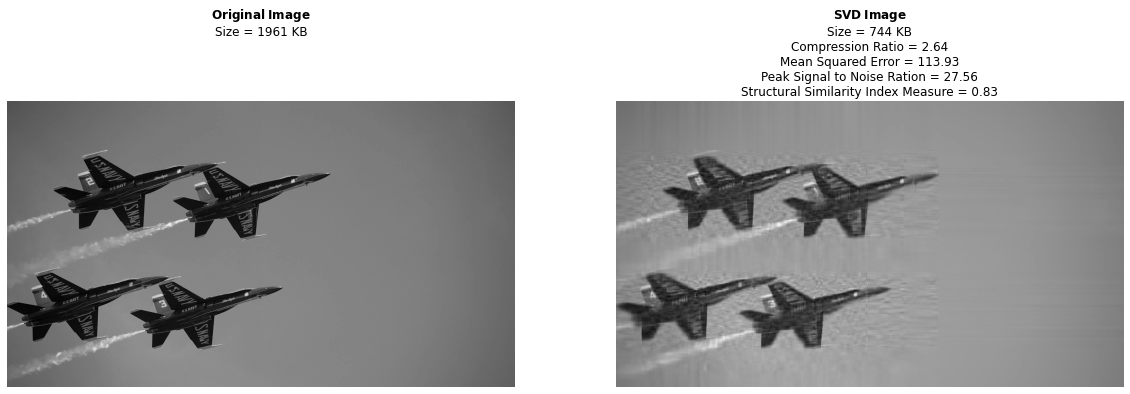

In [12]:
compress_svd_images("Image1",30)

In [13]:
pylab.rcParams['figure.figsize'] = (20.0, 20.0)
def svd_metrics(Image):
    
    k_vs_compression = []
    k_vs_mse = []
    k_vs_psnr = []
    k_vs_ssim = []
    
    image=data_images[Image]
    
    for k in range(10,260,10):
        svd_img = compress_svd(image,k)
    
        cr_svd,original_size,compressed_size = compressionratio(image,svd_img)
        mse_svd = round(get_mse(image,svd_img),2)
        psnr_svd = round(get_psnr(image,svd_img),2)
        ssim_svd = round(get_ssim(image,svd_img),2)
        
        k_vs_compression.append((k,cr_svd))
        k_vs_mse.append((k,mse_svd))
        k_vs_psnr.append((k,psnr_svd))
        k_vs_ssim.append((k,ssim_svd))
        
    f, axarr = plt.subplots(2,2)
    axarr[0,0].plot(*zip(*k_vs_compression))
    axarr[0,1].plot(*zip(*k_vs_mse))
    axarr[1,0].plot(*zip(*k_vs_psnr))
    axarr[1,1].plot(*zip(*k_vs_ssim))
    axarr[0,0].set_title("K vs Compression Ratio",fontsize=18)
    axarr[0,1].set_title("K vs MSE",fontsize=18)
    axarr[1,0].set_title("K vs PSNR",fontsize=18)
    axarr[1,1].set_title("K vs SSIM",fontsize=18)
    axarr[0,0].set_ylabel("Compression Ratio",fontsize=16)
    axarr[0,1].set_ylabel("MSE",fontsize=16)
    axarr[1,0].set_ylabel("PSNR",fontsize=16)
    axarr[1,1].set_ylabel("SSIM",fontsize=16)
    axarr[0,0].set_xlabel("K",fontsize=16)
    axarr[0,1].set_xlabel("K",fontsize=16)
    axarr[1,0].set_xlabel("K",fontsize=16)
    axarr[1,1].set_xlabel("K",fontsize=16)
    axarr[0,0].tick_params(axis='both', which='major', labelsize=14)
    axarr[0,1].tick_params(axis='both', which='major', labelsize=14)
    axarr[1,0].tick_params(axis='both', which='major', labelsize=14)
    axarr[1,1].tick_params(axis='both', which='major', labelsize=14)
    
    f.tight_layout(pad=5.0)
    
    plt.suptitle("Performance Metrics for SVD Compression",fontsize=18)
    
    plt.show()

In [14]:
list_widget = widgets.Dropdown(options=list(data_images.keys()))
interact(svd_metrics,Image=list_widget);

interactive(children=(Dropdown(description='Image', options=('Image1', 'Image2', 'Image3', 'Image4', 'Image5',…

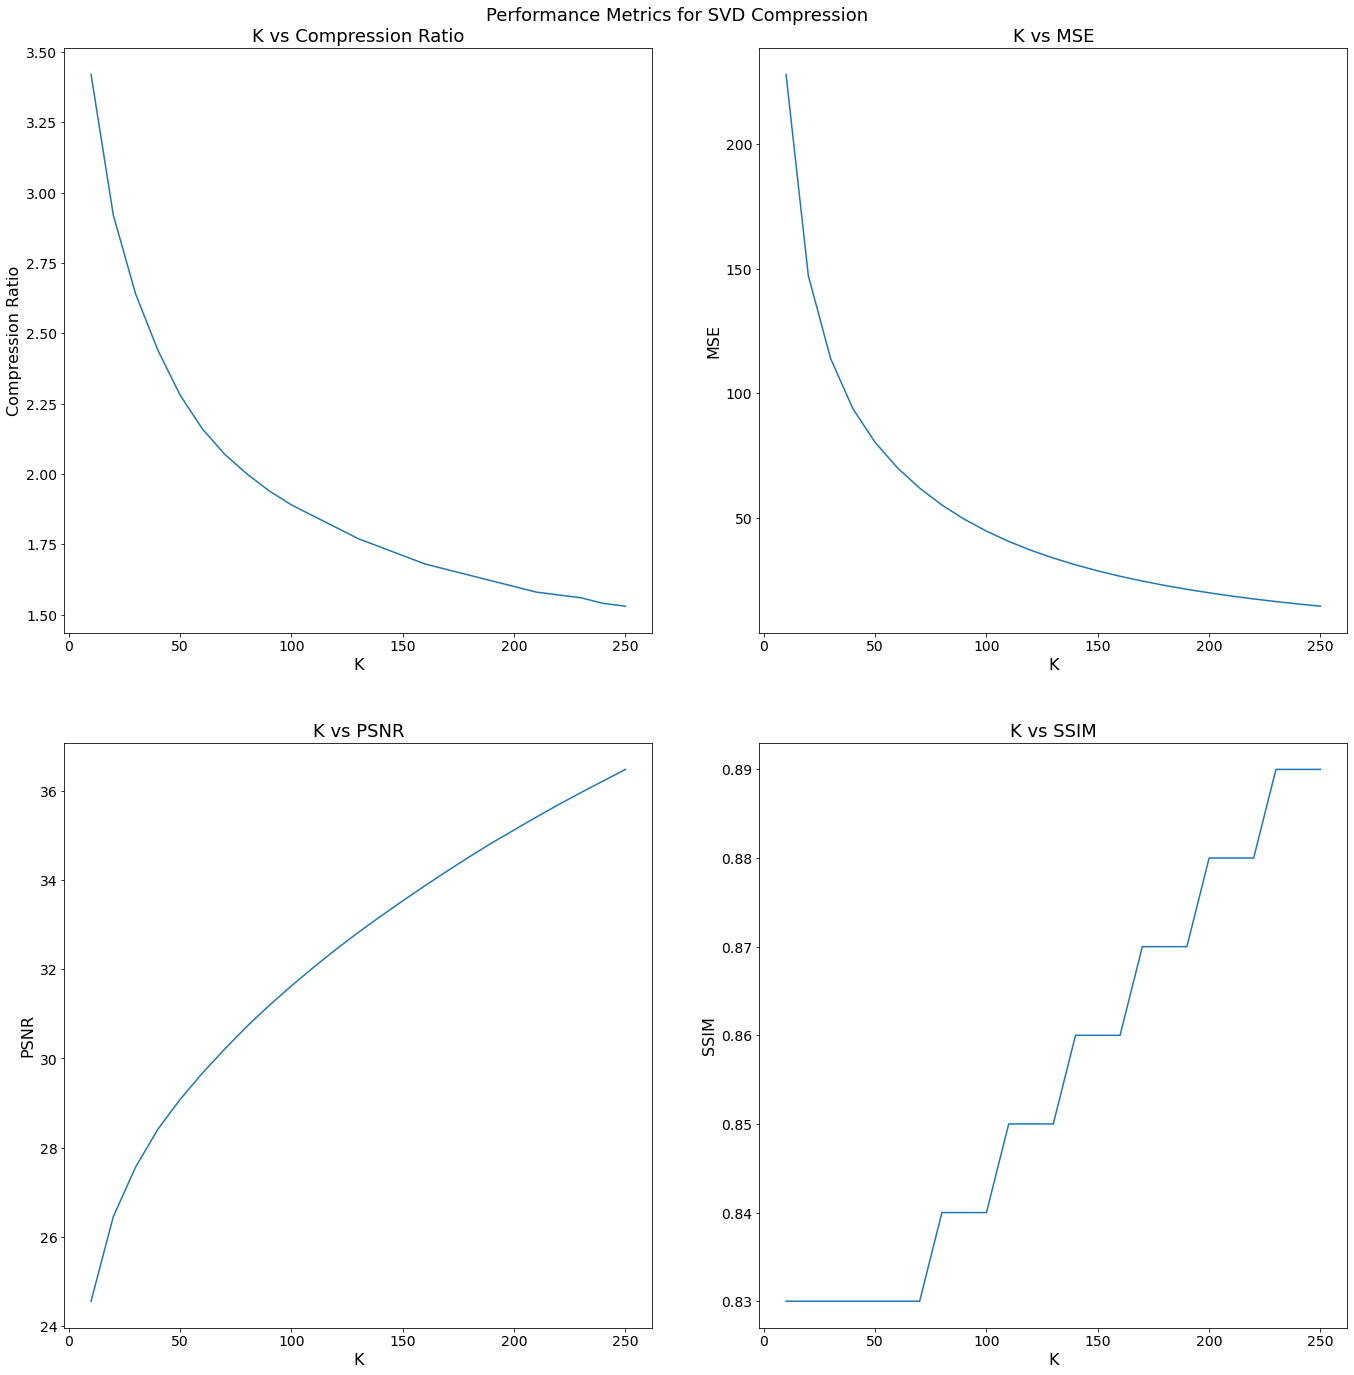

In [15]:
svd_metrics("Image1")

# Performance and Evaluation of DCT on 4k images

In [16]:
pylab.rcParams['figure.figsize'] = (20.0, 7.0)
def compress_dct_images(Image,Threshold):
    image = data_images[Image]
    dct_img = compress_dct(image,Threshold/10000)
    
    cr_dct,original_size,compressed_size = compressionratio(image,dct_img)
    mse_dct = round(get_mse(image,dct_img),2)
    psnr_dct = round(get_psnr(image,dct_img),2)
    ssim_dct = round(get_ssim(image,dct_img),2)
    
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(image,cmap='gray')
    axarr[1].imshow(dct_img,cmap='gray')
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[0].title.set_text(r"$\bf{Original\:Image}$"+"\nSize = {} KB\n\n\n\n".format(round(original_size/1024)))
    axarr[1].title.set_text(r"$\bf{DCT\:Image}$"+"\nSize = {} KB\nCompression Ratio = {}\nMean Squared Error = {}\nPeak Signal to Noise Ration = {}\nStructural Similarity Index Measure = {}".format(round(compressed_size/1024),cr_dct,mse_dct,psnr_dct,ssim_dct))
    

In [17]:
list_widget = widgets.Dropdown(options=list(data_images.keys()))
int_slider_widget = widgets.IntSlider(value=32,min=1,max=50)
print("Threshold will be divided by 10^4 for DCT Calculation")
interact(compress_dct_images,Image=list_widget,Threshold=int_slider_widget);

Threshold will be divided by 10^4 for DCT Calculation


interactive(children=(Dropdown(description='Image', options=('Image1', 'Image2', 'Image3', 'Image4', 'Image5',…

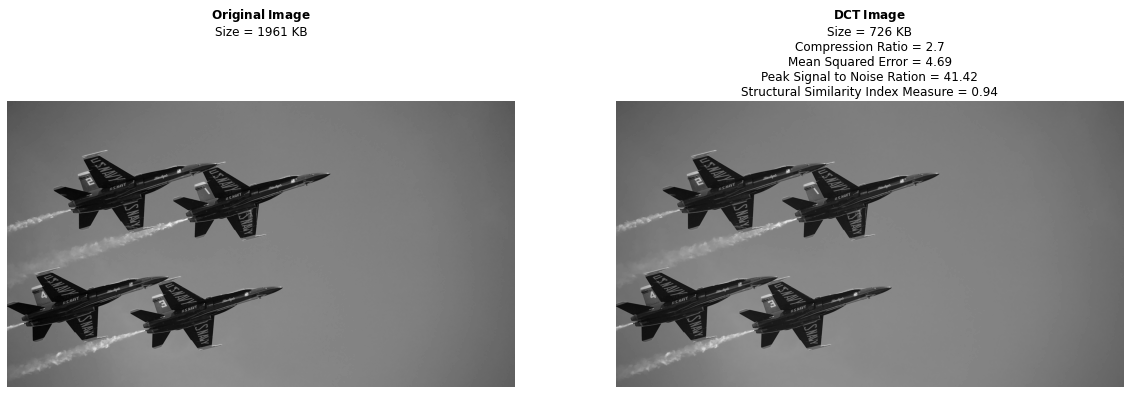

In [18]:
compress_dct_images("Image1",32)

In [19]:
pylab.rcParams['figure.figsize'] = (20.0, 20.0)
def dct_metrics(Image):
    
    thres_vs_compression = []
    thres_vs_mse = []
    thres_vs_psnr = []
    thres_vs_ssim = []
    
    image=data_images[Image]
    
    for thres in range(10,260,10):
        dct_img = compress_dct(image,thres/10000)
    
        cr_dct,original_size,compressed_size = compressionratio(image,dct_img)
        mse_dct = round(get_mse(image,dct_img),2)
        psnr_dct = round(get_psnr(image,dct_img),2)
        ssim_dct = round(get_ssim(image,dct_img),2)
        
        thres_vs_compression.append((thres/10000,cr_dct))
        thres_vs_mse.append((thres/10000,mse_dct))
        thres_vs_psnr.append((thres/10000,psnr_dct))
        thres_vs_ssim.append((thres/10000,ssim_dct))
        
    f, axarr = plt.subplots(2,2)
    axarr[0,0].plot(*zip(*thres_vs_compression))
    axarr[0,1].plot(*zip(*thres_vs_mse))
    axarr[1,0].plot(*zip(*thres_vs_psnr))
    axarr[1,1].plot(*zip(*thres_vs_ssim))
    axarr[0,0].set_title("Threshold vs Compression Ratio",fontsize=18)
    axarr[0,1].set_title("Threshold vs MSE",fontsize=18)
    axarr[1,0].set_title("Threshold vs PSNR",fontsize=18)
    axarr[1,1].set_title("Threshold vs SSIM",fontsize=18)
    axarr[0,0].set_ylabel("Compression Ratio",fontsize=16)
    axarr[0,1].set_ylabel("MSE",fontsize=16)
    axarr[1,0].set_ylabel("PSNR",fontsize=16)
    axarr[1,1].set_ylabel("SSIM",fontsize=16)
    axarr[0,0].set_xlabel("Threshold",fontsize=16)
    axarr[0,1].set_xlabel("Threshold",fontsize=16)
    axarr[1,0].set_xlabel("Threshold",fontsize=16)
    axarr[1,1].set_xlabel("Threshold",fontsize=16)
    axarr[0,0].tick_params(axis='both', which='major', labelsize=14)
    axarr[0,1].tick_params(axis='both', which='major', labelsize=14)
    axarr[1,0].tick_params(axis='both', which='major', labelsize=14)
    axarr[1,1].tick_params(axis='both', which='major', labelsize=14)
    
    f.tight_layout(pad=5.0)
    
    plt.suptitle("Performance Metrics for DCT Compression",fontsize=18)
    
    plt.show()

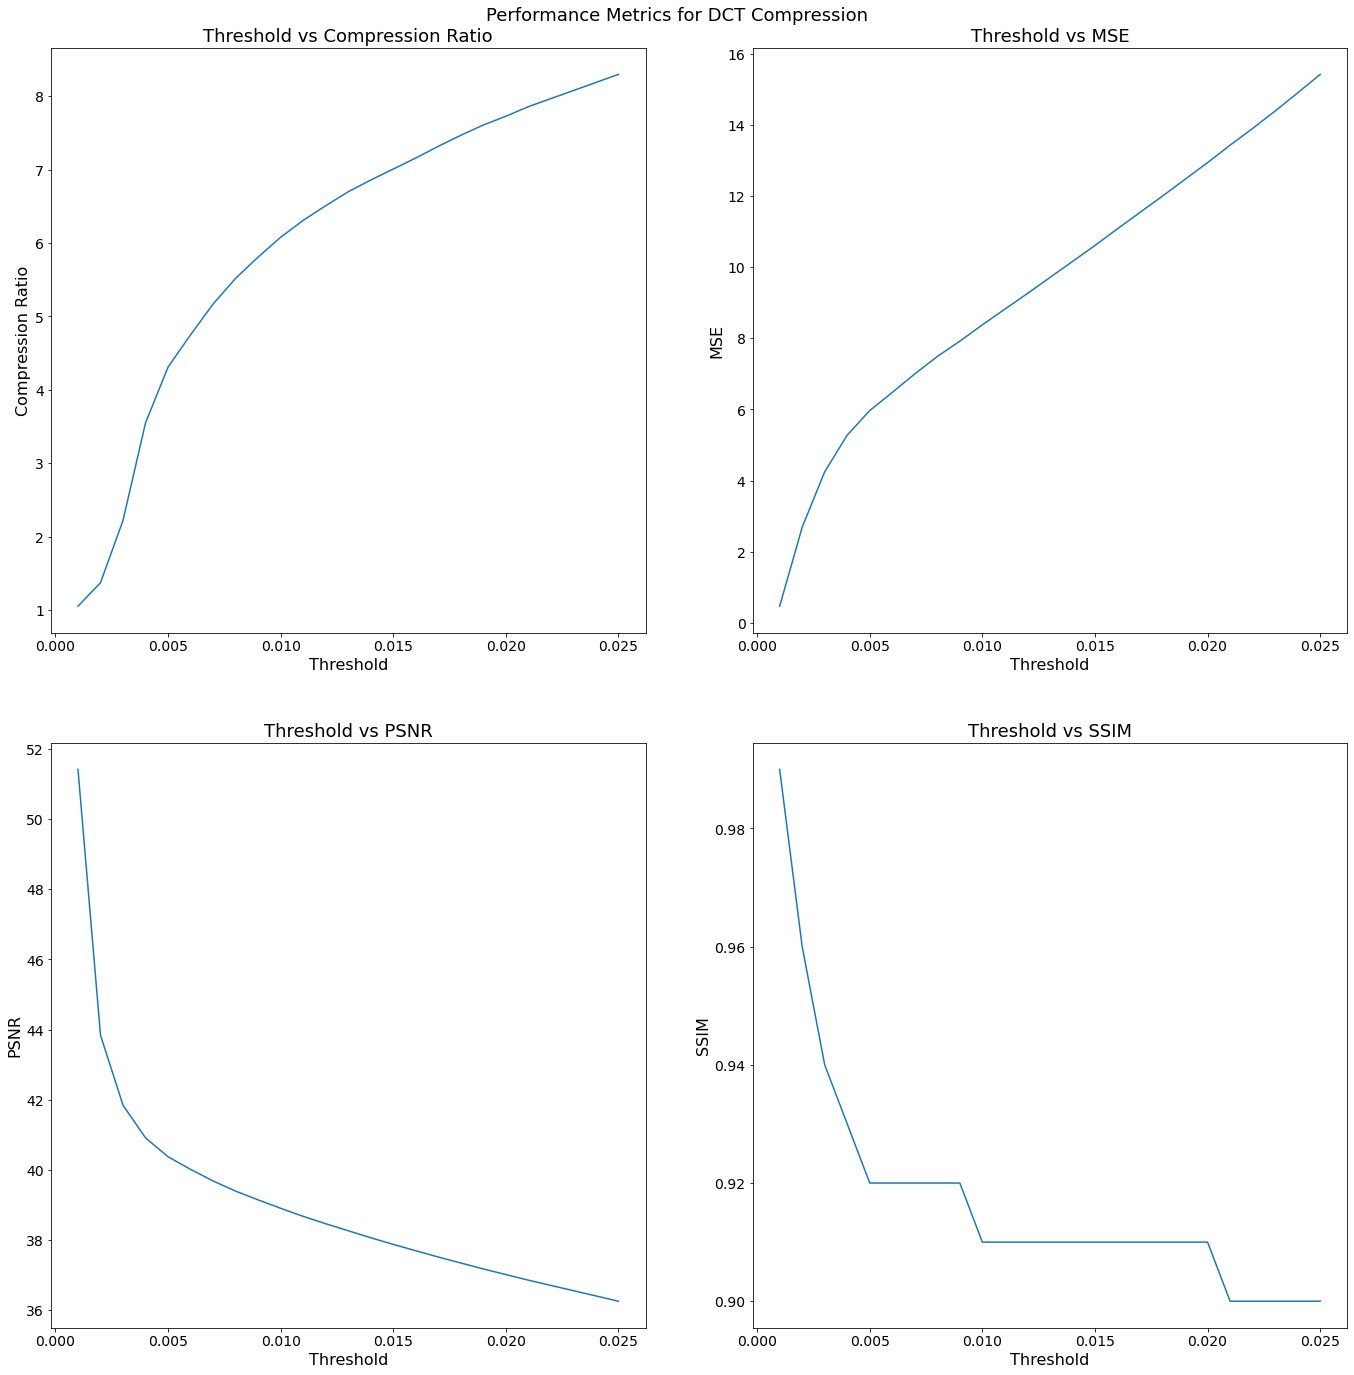

In [20]:
dct_metrics("Image1")

In [21]:
pylab.rcParams['figure.figsize'] = (20.0, 10.0)
def compare_dct_svd_images(Image):
    image = data_images[Image]
    svd_img = compress_svd(image,30)
    
    dct_img = compress_dct(image,32/10000)
    
    cr_svd,original_size,size_svd = compressionratio(image,svd_img)
    mse_svd = round(get_mse(image,svd_img),2)
    psnr_svd = round(get_psnr(image,svd_img),2)
    ssim_svd = round(get_ssim(image,svd_img),2)
    
    cr_dct,original_size,size_dct = compressionratio(image,dct_img)
    mse_dct = round(get_mse(image,dct_img),2)
    psnr_dct = round(get_psnr(image,dct_img),2)
    ssim_dct = round(get_ssim(image,dct_img),2)
    
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(image,cmap='gray')
    axarr[1].imshow(svd_img,cmap='gray')
    axarr[2].imshow(dct_img,cmap='gray')
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[2].axis('off')
    axarr[0].title.set_text(r"$\bf{Original\:Image}$"+"\nSize = {} KB\n\n\n\n".format(round(original_size/1024)))
    axarr[1].title.set_text(r"$\bf{SVD\:Image}$"+"\nSize = {} KB\nCompression Ratio = {}\nMean Squared Error = {}\nPeak Signal to Noise Ration = {}\nStructural Similarity Index Measure = {}".format(round(size_svd/1024),cr_svd,mse_svd,psnr_svd,ssim_svd))
    axarr[2].title.set_text(r"$\bf{DCT\:Image}$"+"\nSize = {} KB\nCompression Ratio = {}\nMean Squared Error = {}\nPeak Signal to Noise Ration = {}\nStructural Similarity Index Measure = {}".format(round(size_dct/1024),cr_dct,mse_dct,psnr_dct,ssim_dct))
    plt.axis('off')

In [22]:
list_widget = widgets.Dropdown(options=list(data_images.keys()))
interact(compare_dct_svd_images,Image=list_widget);

interactive(children=(Dropdown(description='Image', options=('Image1', 'Image2', 'Image3', 'Image4', 'Image5',…

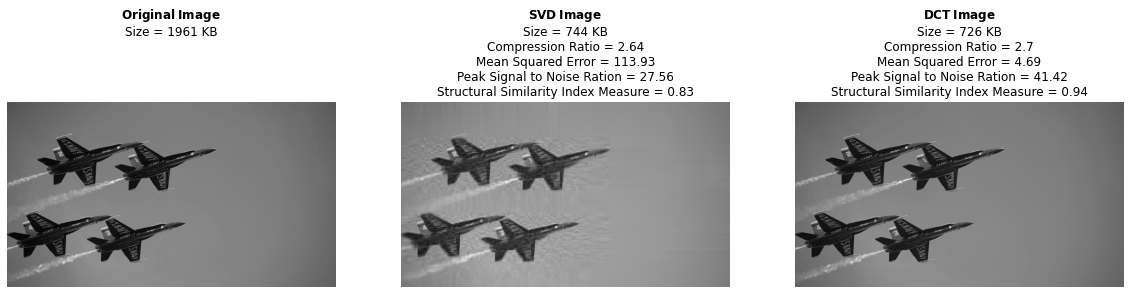

In [23]:
compare_dct_svd_images("Image1")

In [24]:
def dataset_run(data_images):
    final = []
    for name, image in data_images.items():
        
        metric_dict = {}
        
        svd_img = compress_svd(image,30)
        dct_img = compress_dct(image,32/10000)
        
        cr_svd,original_size,size_svd = compressionratio(image,svd_img)
        cr_dct,original_size,size_dct = compressionratio(image,dct_img)
        
        final.append({
            "Image": name,
            "Original Size": round(original_size/1024),
            "SVD Compressed Size":round(size_svd/1024),
            "SVD Compression Ratio": cr_svd,
            "SVD MSE": round(get_mse(image,svd_img),2),
            "SVD PSNR": round(get_psnr(image,svd_img),2),
            "SVD SSIM": round(get_ssim(image,svd_img),2),
            "DCT Compressed Size":round(size_dct/1024),
            "DCT Compression Ratio": cr_dct,
            "DCT MSE": round(get_mse(image,dct_img),2),
            "DCT PSNR": round(get_psnr(image,dct_img),2),
            "DCT SSIM": round(get_ssim(image,dct_img),2)
        })
        
    return final

In [25]:
result = dataset_run(data_images)
result_df = pd.DataFrame(result)

In [26]:
result_df

,Image,Original Size,SVD Compressed Size,SVD Compression Ratio,SVD MSE,SVD PSNR,SVD SSIM,DCT Compressed Size,DCT Compression Ratio,DCT MSE,DCT PSNR,DCT SSIM
0,Image1,1961,744,2.64,113.93,27.56,0.83,726,2.70,4.69,41.42,0.94
1,Image2,2808,1627,1.73,642.26,20.05,0.47,2793,1.01,0.24,54.38,1.00
2,Image3,1485,831,1.79,68.98,29.74,0.84,679,2.19,2.53,44.10,0.97
3,Image4,1338,607,2.20,11.38,37.57,0.94,378,3.54,2.22,44.68,0.97
4,Image5,2384,1342,1.78,361.31,22.55,0.68,1636,1.46,4.28,41.82,0.96
...,...,...,...,...,...,...,...,...,...,...,...,...
95,Image96,2208,1157,1.91,174.96,25.70,0.64,2040,1.08,1.29,47.02,0.99
96,Image97,4204,1972,2.13,616.39,20.23,0.20,4204,1.00,0.09,58.36,1.00
97,Image98,2020,993,2.03,89.05,28.63,0.82,972,2.08,4.45,41.64,0.94
98,Image99,2545,1219,2.09,259.51,23.99,0.67,2121,1.20,2.14,44.82,0.98


In [27]:
result_df.to_csv("Results.csv",index=False)

In [32]:
print("Average for 100 4k Images.\nSVD K=30 and DCT Threshold = 0.0032")
pd.DataFrame(result_df.mean()).T

Average for 100 4k Images.
SVD K=30 and DCT Threshold = 0.0032


,Original Size,SVD Compressed Size,SVD Compression Ratio,SVD MSE,SVD PSNR,SVD SSIM,DCT Compressed Size,DCT Compression Ratio,DCT MSE,DCT PSNR,DCT SSIM
0,2217.49,1209.67,1.8575,353.7112,24.9155,0.658,1793.57,1.5071,1.8203,47.2065,0.9822
